In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import keras_tuner

from openpyxl import load_workbook
from itertools import product

from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import matplotlib.pyplot as plt

In [2]:
sensor = 's'
fill = '_fill'
district = 'Mean'

path = '../data/'

data = pd.read_csv(f"{path}pm25_{sensor}{fill}.csv", sep = ';', index_col = ['Date'], parse_dates = ['Date'], usecols = ['Date', district])

In [3]:
def CreateData(X_in, y_in, n_steps):
    '''Формирование данных для входа LSTM (n_samples, n_steps, n_features)
    '''
    
    X = []
    y = []
    for i in range(len(X_in) - n_steps):
        X.append(X_in[i:i + n_steps])
        y.append(y_in[i + n_steps])
    return np.array(X).reshape(-1, n_steps, X_in.shape[1]),   np.array(y)


def FitModel(X_train, y_train, X_valid, y_valid, n_steps, units = 128, epochs = 200, dropout = 0):
    '''Построение модели LSTM
    '''
    
    model = Sequential([
        LSTM(units, input_shape = (n_steps, X_train.shape[2]), dropout = dropout),
        Dense(1)
    ])

    # Компиляция модели
    model.compile(optimizer = 'adam', loss = 'mse')

    # Обучение модели
    model.fit(X_train, y_train, epochs = epochs, validation_data = (X_valid, y_valid), verbose = 0)
    
    return model


def Metrics(y, y_pred):
    '''Вычисление метрик качества'''
    
    mse = round(mean_squared_error(y, y_pred), 2)
    mae = round(mean_absolute_error(y, y_pred), 2)
    mape = round(mean_absolute_percentage_error(y, y_pred), 2)
    R2 = round(r2_score(y, y_pred), 2)
    
    return [mse, mae, mape, R2]

def CompareGraph(x, y1, y2, l1, l2, title):
    '''Сравнение двух функций на одном макете
    '''
    
    plt.figure(figsize = (11, 4))
        
    plt.plot(x, y1, label = l1)
    plt.plot(x, y2, label = l2)

    plt.title(title)
        
    plt.xlabel('Время (YYYY-MM-DD)')
    plt.ylabel('PM 2.5, мкг/м³')
    plt.legend()
    plt.grid()

def LSTM_Forecast(data, begin, end, params, test_days = 3, n_steps = [5], val_size = 0.8, plotVal = False, plotTest = False, savePath = '', sheet_name = 'LSTM Results'):
    ''' Построение модели LSTM с подбором гиперпараметров
    '''
    
    best_model_score = np.inf
    best_model = 0
    
    best_params = {}
    
    # Подбор гиперпараметра, на сколько шагов модель смотрит в прошлое (ограничение на кол-во блоков RNN)
    for steps in n_steps:
        df = data[begin : end].copy()
        
        val_index = int((df.shape[0] - test_days - steps) * val_size)
        
        X = df.values
        y = df['Mean'].values
        
        # Формирование данных для входа LSTM (n_samples, n_steps, n_features)
        X, y = CreateData(X, y, steps)
        
        X_train, y_train = X[: val_index], y[: val_index]
        X_valid, y_valid = X[val_index : -test_days], y[val_index : -test_days]
        X_test, y_test = X[-test_days : ], y[-test_days : ]
        
        print('Размерности train, valid, test: ', X_train.shape, X_valid.shape, X_test.shape)
        
        
        # Подбор оптимальных гиперпараметров LSTM
        for param in product(params['units'], params['epochs'], params['dropout']):

            units, epochs, dropout = param

            model = FitModel(X_train, y_train, X_valid, y_valid, steps, units, epochs, dropout)
            mse = mean_squared_error(model.predict(X_valid), y_valid)
            

            if mse < best_model_score:
                best_model_score = mse
                best_model = model

                
                y_val_pred = model.predict(X_valid)
                y_test_pred = model.predict(X_test)
                y_val_best = y_valid
                y_test_best = y_test
                
                bestValIndex = val_index
                
                metrics = pd.DataFrame(data = {'Train' : Metrics(y_train, model.predict(X_train)),
                                   'Valid' : Metrics(y_valid, y_val_pred),
                                   'Test' : Metrics(y_test, y_test_pred)
                                  }, index = ['MSE' ,'MAE', 'MAPE', 'R2'])
                
                
                best_params['units'] = units
                best_params['epochs'] = epochs
                best_params['dropout'] = dropout
                best_params['n_steps'] = steps
                
                metrics.index.name = f'{begin} – {end}. {best_params}'
    
    model = best_model
    
    display(metrics)
    
    if plotVal:
        CompareGraph(df[bestValIndex + best_params['n_steps']: -test_days].index, y_val_best, y_val_pred, 'Истинные значения', 'Прогнозируемые значения', 'Качество прогнозирования на валидационной выборке')
    
    if plotTest:
        CompareGraph(df[-test_days :].index, y_test_best, y_test_pred, 'Истинные значения', 'Прогнозируемые значения', 'Качество прогнозирования на тестовой выборке')
    
    # Сохранение в файл
    if savePath:
        
        # Номер последней строки в файле
        numRow = 0
        wb = load_workbook(savePath)
        if sheet_name in wb.sheetnames:
            numRow = wb[sheet_name].max_row + 2
        
        with pd.ExcelWriter(savePath, engine="openpyxl", mode = 'a', if_sheet_exists='overlay') as writer:
            metrics.to_excel(writer, sheet_name = sheet_name, startrow = numRow)
    
    return best_model

Размерности train, valid, test:  (60, 1, 1) (15, 1, 1) (3, 1, 1)
1/1 [==============================] - 0s 469ms/step
Размерности train, valid, test:  (59, 2, 1) (15, 2, 1) (3, 2, 1)
1/1 [==============================] - 0s 469ms/step
Размерности train, valid, test:  (58, 3, 1) (15, 3, 1) (3, 3, 1)


1/1 [==============================] - 0s 453ms/step
Размерности train, valid, test:  (56, 5, 1) (15, 5, 1) (3, 5, 1)
1/1 [==============================] - 0s 453ms/step
Размерности train, valid, test:  (55, 7, 1) (14, 7, 1) (3, 7, 1)
1/1 [==============================] - 0s 453ms/step
Размерности train, valid, test:  (52, 10, 1) (14, 10, 1) (3, 10, 1)
1/1 [==============================] - 0s 453ms/step


1/1 [==============================] - 0s 453ms/step


,Train,Valid,Test
"2024-01-01 – 2024-03-19. {'units': 32, 'epochs': 300, 'dropout': 0, 'n_steps': 3}",,,
MSE,4346.90,168.20,180.06
MAE,51.60,9.32,13.40
MAPE,1.04,0.48,2.01
R2,-0.62,0.02,-3026.97


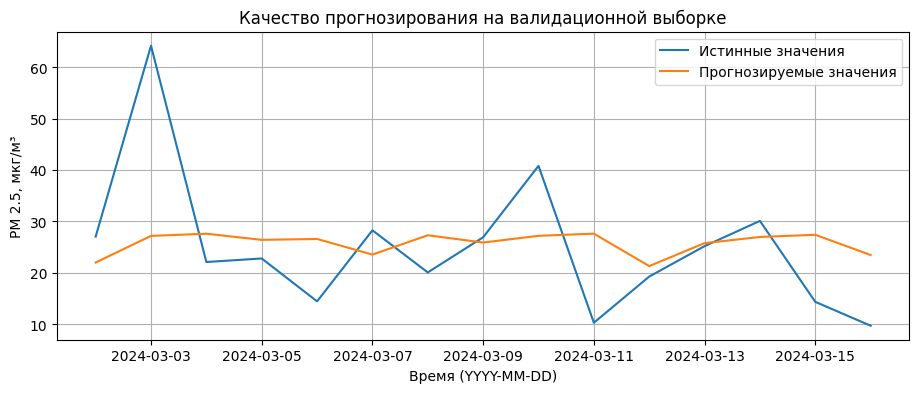

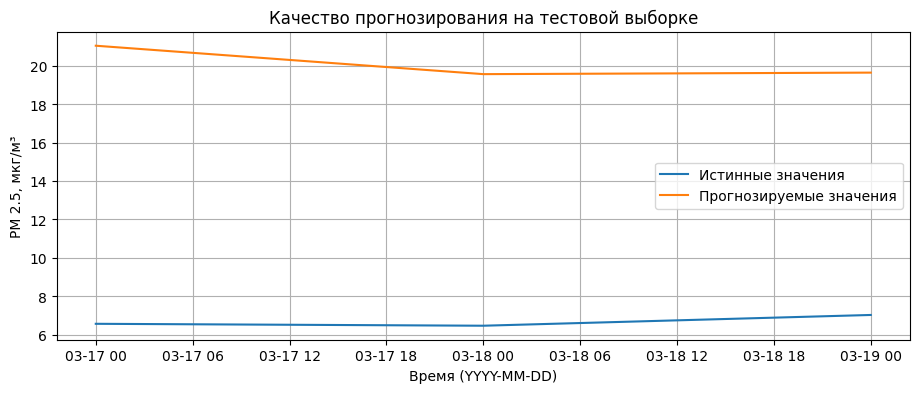

In [4]:
# No STD
params = {'units' : [32, 64, 128, 256], 'epochs' : [50, 100, 200, 300], 'dropout' : [0, 0.02, 0.1]}

model = LSTM_Forecast(data, '2024-01-01', '2024-03-19', params, n_steps = [1, 2, 3, 5, 7, 10], plotVal = True, plotTest = True, savePath = 'Results/LSTM.xlsx')